In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
!unzip brain-tumor-mri-dataset.zip

cp: kaggle.json: No such file or directory
Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
  0%|                                                | 0.00/149M [00:00<?, ?B/s]
100%|████████████████████████████████████████| 149M/149M [00:00<00:00, 6.51GB/s]
Archive:  brain-tumor-mri-dataset.zip
  inflating: Testing/glioma/Te-glTr_0000.jpg  
  inflating: Testing/glioma/Te-glTr_0001.jpg  
  inflating: Testing/glioma/Te-glTr_0002.jpg  
  inflating: Testing/glioma/Te-glTr_0003.jpg  
  inflating: Testing/glioma/Te-glTr_0004.jpg  
  inflating: Testing/glioma/Te-glTr_0005.jpg  
  inflating: Testing/glioma/Te-glTr_0006.jpg  
  inflating: Testing/glioma/Te-glTr_0007.jpg  
  inflating: Testing/glioma/Te-glTr_0008.jpg  
  inflating: Testing/glioma/Te-glTr_0009.jpg  
  inflating: Testing/glioma/Te-gl_0010.jpg  
  inflating: Testing/glioma/Te-gl_0011.jpg  
  inflating: Testing/glioma/Te-gl_0012.jpg  
  inflating: Testing/glioma/Te-gl_0013.jpg  
 

Using device: mps
Epoch 1/100 => Train Loss: 1.1504, Train Acc: 0.7123 | Val Loss: 1.4566, Val Acc: 0.6171
Best model saved
Epoch 2/100 => Train Loss: 0.4722, Train Acc: 0.8391 | Val Loss: 1.6198, Val Acc: 0.6486
Epoch 3/100 => Train Loss: 0.3977, Train Acc: 0.8650 | Val Loss: 0.7524, Val Acc: 0.7745
Best model saved
Epoch 4/100 => Train Loss: 0.2980, Train Acc: 0.8959 | Val Loss: 0.6387, Val Acc: 0.8164
Best model saved
Epoch 5/100 => Train Loss: 0.2757, Train Acc: 0.9016 | Val Loss: 2.1736, Val Acc: 0.5787
Epoch 6/100 => Train Loss: 0.2206, Train Acc: 0.9214 | Val Loss: 0.3573, Val Acc: 0.8969
Best model saved
Epoch 7/100 => Train Loss: 0.2164, Train Acc: 0.9224 | Val Loss: 0.2936, Val Acc: 0.8951
Best model saved
Epoch 8/100 => Train Loss: 0.2058, Train Acc: 0.9296 | Val Loss: 0.4917, Val Acc: 0.8619
Epoch 9/100 => Train Loss: 0.1543, Train Acc: 0.9473 | Val Loss: 0.3062, Val Acc: 0.8986
Epoch 10/100 => Train Loss: 0.1477, Train Acc: 0.9467 | Val Loss: 0.1566, Val Acc: 0.9493
Best m

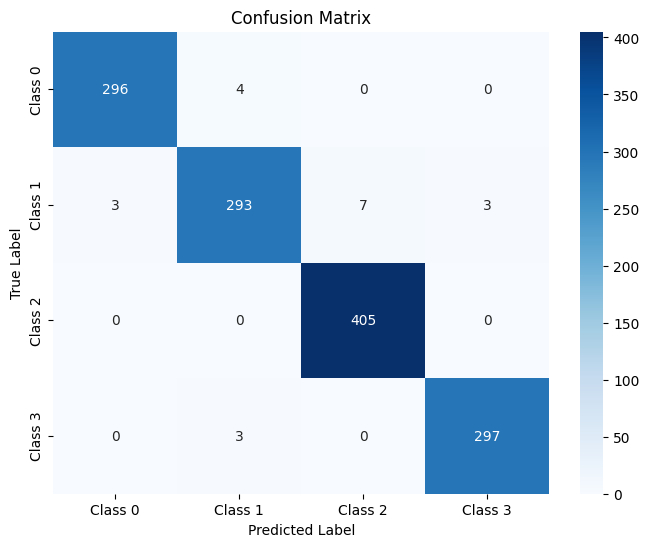

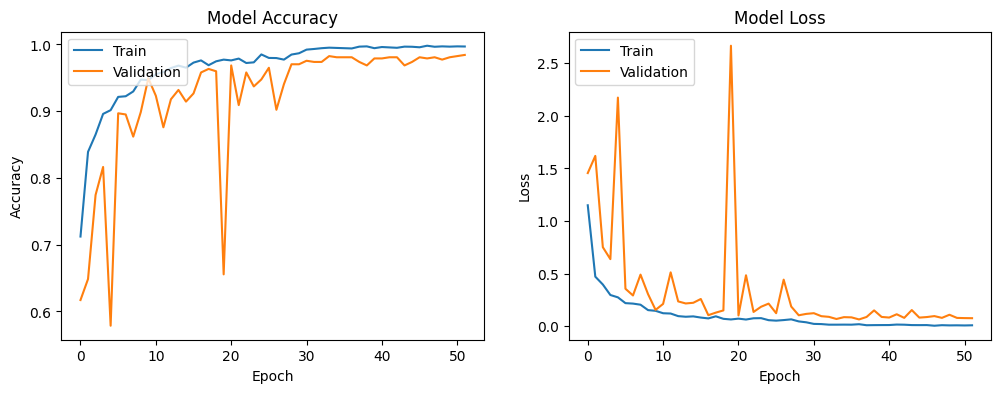

In [4]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torch.optim import AdamW
from torch.amp import autocast
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

# Hyperparameters
batch_size = 64
num_classes = 4
epochs = 100
learning_rate = 5e-4  # Middle ground between 1e-3 and 1e-4
image_size = 224  # Revert to original for stability 128
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Compute dataset-specific mean and std (approximated; ideally compute from train images)
# For MRI, approximate grayscale-like normalization (adjust if you have exact values)
train_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),  # Reduced for MRI
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Grayscale-like; adjust if RGB
])

test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Datasets
base_path = "/Users/arindam/Documents/playground/ML/MRi brain tumor - mac"
train_dataset = ImageFolder(f"{base_path}/Training", transform=train_transform)
test_dataset = ImageFolder(f"{base_path}/Testing", transform=test_transform)

# Train/Validation Split (90/10)
train_len = int(0.9 * len(train_dataset))
val_len = len(train_dataset) - train_len
train_ds, val_ds = random_split(train_dataset, [train_len, val_len], generator=torch.Generator().manual_seed(42))

# Dataloaders
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)

# Model: Hybrid of original and residual blocks
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),  # Original dropout
            ResidualBlock(32, 64),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
            ResidualBlock(64, 128),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),  # Keep original final conv
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            # nn.Linear(128 * 8 * 8, 512),  # For 128x128 input
            nn.Linear(128 * 14 * 14, 512), # for 224 image size
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = self.fc(x)
        return x

# Model instance
model = CNNModel(num_classes).to(device)

# Class weights (approximated from test set; adjust with train set counts if available)
class_counts = [300, 306, 405, 300]  # Estimate; replace with train set counts
weights = torch.tensor([1.0 / c for c in class_counts], dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)

# Optimizer with weight decay
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)

# LR Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7)

# Training loop
def train(model, loader, optimizer, criterion):
    model.train()
    running_loss, correct = 0.0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        with autocast(device_type="mps" if device.type == "mps" else "cpu"):
            outputs = model(images)
            loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
    return running_loss / len(loader.dataset), correct / len(loader.dataset)

# Evaluation loop
def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct = 0.0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            with autocast(device_type="mps" if device.type == "mps" else "cpu"):
                outputs = model(images)
                loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
    return running_loss / len(loader.dataset), correct / len(loader.dataset)

# Initialize metrics lists
train_accuracies, val_accuracies, train_losses, val_losses = [], [], [], []

# Early stopping parameters
patience = 15  # Increased for deeper model
best_val_loss = float('inf')
counter = 0

# Run training with early stopping
for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} => "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Scheduler step
    scheduler.step(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "best_model.pth")
        print("Best model saved")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered")
            break

# Load best model for evaluation
model.load_state_dict(torch.load("best_model.pth"))

# Final evaluation
test_loss, test_acc = evaluate(model, test_loader, criterion)
train_loss, train_acc = evaluate(model, train_loader, criterion)
print(f"\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")

# Save final model
torch.save(model.state_dict(), "model_weights.pth")
print("Model saved to model_weights.pth")

# Generate predictions on test set
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Metrics
f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1', 'Class 2', 'Class 3']))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'],
            yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot accuracy and loss
if train_accuracies:
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracies, label='Train')
    plt.plot(val_accuracies, label='Validation')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()